In [1]:
%matplotlib inline

import os
import warnings
import collections
import time
import datetime

from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH '] = '1'

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from pandas.plotting import register_matplotlib_converters

import util_functions as util
import option_pricing.option_pricing as options

register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

# show gpu status, fix memory growth
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:

    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "physical GPUs,", len(logical_gpus), "logical GPUs", logical_gpus)

    except RuntimeError as e:
        print(e)

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )


tf version : 2.2.0
tfp version: 0.9.0


In [2]:

dataset_headers = ['date-time','O','H','L','C','V']
dataset_dtype = 'float32'
dataset_dtypes = {'O':dataset_dtype,'H':dataset_dtype,'L':dataset_dtype,'C':dataset_dtype,'V':'int32'}
dataset_file = '../../../lambda-asset-corpus/ALL/XAUUSD_1M_ALL.csv'
dataset_sep = ';'

dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )

# e.g., 20090315 181200
dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y%m%d %H%M%S')
dataset = dataset.set_index( ['date-time'] )
dataset.tail(10)


,O,H,L,C,V
date-time,,,,,
2018-12-31 16:49:00,1282.526001,1282.584961,1282.526001,1282.579956,0
2018-12-31 16:50:00,1282.555054,1282.579956,1282.380981,1282.550049,0
2018-12-31 16:51:00,1282.541016,1282.551025,1282.500977,1282.522949,0
2018-12-31 16:52:00,1282.488037,1282.505005,1282.475952,1282.484985,0
2018-12-31 16:53:00,1282.493042,1282.493042,1282.489990,1282.489990,0
2018-12-31 16:54:00,1282.484985,1282.484985,1282.425049,1282.432983,0
2018-12-31 16:55:00,1282.420044,1282.598022,1282.420044,1282.598022,0
2018-12-31 16:56:00,1282.598022,1282.647949,1282.454956,1282.505005,0
2018-12-31 16:57:00,1282.494995,1282.547974,1282.447998,1282.547974,0


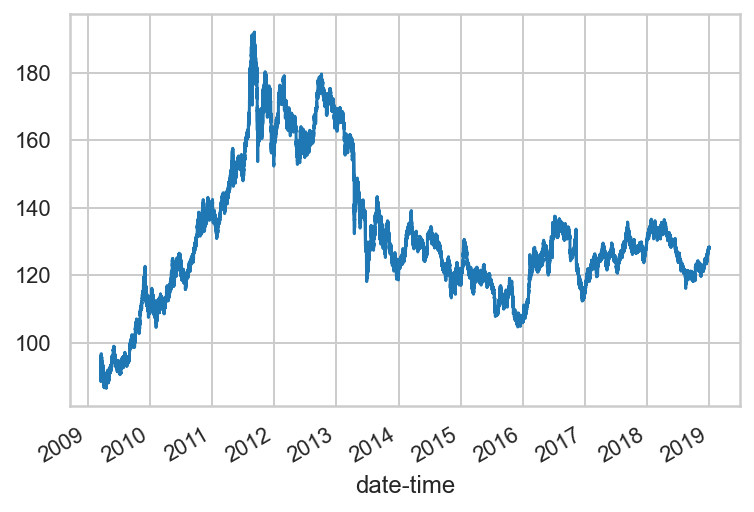

In [3]:
close = dataset['C'] / 10
close_dayofweek = close.index.dayofweek
close_monthofyear = close.index.month

_ = close.plot()


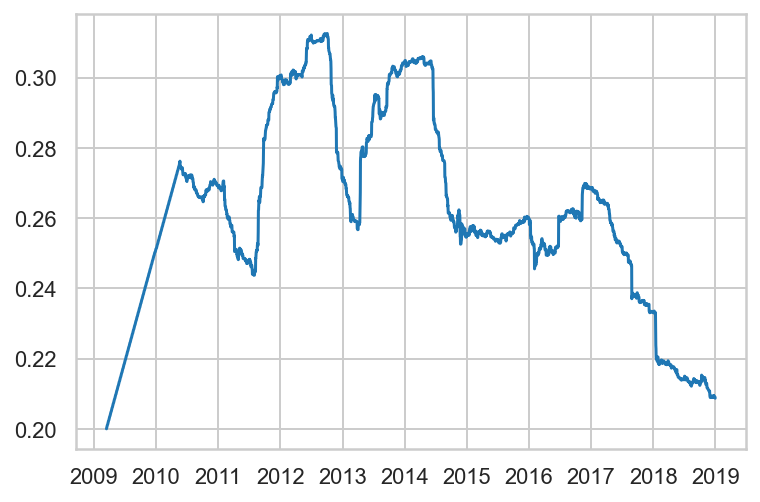

In [4]:

daily = close.groupby( by=close.index.date ).apply( lambda x: x[0] )
daily_days = close.groupby( by=close.index.date ).apply( lambda x: x.index[0] )
hv = daily.pct_change().rolling( 365 ).std() * ( 252 ** 0.5 ) + 0.125
hv[0:365] = np.arange( start=0.2, stop=hv[365], step=(hv[365]-0.2)/365 )

_ = plt.plot( hv )


In [5]:
close.size / 1440


2393.995138888889

In [6]:

# the day of the week with Monday=0, Friday=4, Sunday=6
close_dayofweek_sample = close.tail(144000).index.dayofweek
close_monthofyear_sample = close.tail(144000).index.month

#_ = plt.plot( close_dayofweek_sample )
#_ = plt.plot( close_monthofyear_sample )

friday = 4
open_hourofday = 10     # 10am
close_hourofday = 16    # 4pm


In [30]:
# constant parameters
expire = 7                  # expiration interval
oom = 1                     # options offered at each $5 strike interval
vol = 0.2                   # historical median IV
commission = 0.65 / 100     # option contract commission per share (not per contract)
spread = 0.05               # option price difference between bid and ask

# starting state
state = 'cash'

# preinitialized tracking variables
balance = [ 100000 ]
closes = [ close[0] ]
profits = [ 0 ]

# additional tracking variables
# initialized during cash state
strikes = []
calls = []
timestamps = []

# realize profit or loss even when underlying is moving downward
variation_realize_underlying_loss = True
variation_expire_reenter_loss = False
variation_close_worthless = True

for i, c in enumerate(close):

    # check only between 9am and 4pm
    hourofday = close.index[ i ].hour
    if hourofday >= open_hourofday and hourofday < close_hourofday:

        # state transitions
        # cash      - start from cash, open new positions
        # waiting   - waiting for end of option expiration
        # opened    - close old position(s), and open new
        if state == 'cash':

            # open underlying
            cost = c
            lots = np.floor( ( balance[-1] / c ) / 100 )

            # open new sell call position
            # sell an OOM call option (note, price is in $/share, not $/100 shares)
            # cost   - cost of underlying asset
            # strike - the nearest OOM strike above the cost
            # c      - the current price of the underlying asset
            vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
            strike = oom * np.round( np.ceil( cost + oom ) / oom )
            call_in = options.american( "c", c, strike, expire/365, 0.01, 0.0, vol )[0] - spread
            
            # track progress
            strikes.append( strike )
            calls.append( call_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format(expire) )
            state = 'waiting'

        elif state == 'waiting':

            # wait for expiration
            if close.index[ i ] > timestamp - pd.Timedelta( '1D' ):

                state = 'expired'

            elif c > strike:

                state = 'exercised'

            elif variation_close_worthless:

                vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
                days = ( timestamp - close.index[ i ] ).days
                call_out = options.american( "c", c, strike, days/365, 0.01, 0.0, vol )[0]
                if call_out < 0.05:

                    state = 'expired'

        elif state == 'expired':

            # CLOSE OLD POSITION
            # opt. calculate call_out if closing early
            call_out = 0.0
            if ( timestamp - close.index[ i ] ).days > 0:

                vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
                days = ( timestamp - close.index[ i ] ).days
                call_out = options.american( "c", c, strike, days/365, 0.01, 0.0, vol )[0]

            elif c > strike:

                call_out = ( c - strike )

            # the call option expired worthless
            # so, we can keep the original sale price
            profit = call_in - call_out
            
            # opt. calculate profit (loss) for the close of the underlying position
            if variation_realize_underlying_loss:

                # subtract loss or add slight gain (no commission)
                profit = profit + c - cost

            # track progress
            balance.append( balance[-1] + profit * 100 * lots - commission * 100 * lots * 2 )
            profits.append( profit )
            closes.append( c )

            # OPEN NEW POSITION
            # opt. close underlying position
            reenter = cost
            if variation_realize_underlying_loss:

                # open a new position in underlying
                cost = c
                reenter = c
                lots = np.floor( ( balance[-1] / c ) / 100 )

            elif variation_expire_reenter_loss:

                reenter = c

            # sell an OOM call option (note, price is in $/share, not $/100 shares)
            # cost   - cost of underlying asset (not necessarily the same as the current price)
            # strike - the nearest OOM strike above the cost
            # c      - the current price of the underlying asset
            vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
            strike = oom * np.round( np.ceil( reenter + oom ) / oom )
            call_in = options.american( "c", reenter, strike, expire/365, 0.01, 0.0, vol )[0] - spread

            # track strike and lots progress
            strikes.append( strike )
            calls.append( call_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format(expire) )
            state = 'waiting'

        elif state == 'exercised':

            # CLOSE OLD POSITION
            # option was exercised early (it didnt expire)
            # calculate days remaining (remember, timestamp = start + expire time)
            call_out = 0.0
            if ( timestamp - close.index[ i ] ).days > 0:

                vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
                days = ( timestamp - close.index[ i ] ).days
                call_out = options.american( "c", c, strike, days/365, 0.01, 0.0, vol )[0]
            
            elif c > strike:
                
                call_out = c - strike

            # add profit (loss) from the purchase of the call (to close the short sale at the start)
            profit = call_in - call_out

            # add profit (loss) from sale of underlying (no commission)
            profit = profit + c - cost

            # track progress
            balance.append( balance[ -1 ] + profit * 100 * lots - commission * 100 * lots * 2 )
            profits.append( profit )
            closes.append( c )

            # OPEN NEW POSITION
            # open new underlying
            cost = c
            lots = np.floor( ( balance[-1] / c ) / 100 )

            # sell another call in the remaining expire time plus another full expire
            expire_plus = days + expire
            strike = oom * np.round( np.ceil( cost + oom ) / oom )
            call_in = options.american( "c", c, strike, expire_plus/365, 0.01, 0.0, vol )[0] - spread

            # track strike and lots progress
            strikes.append( strike )
            calls.append( call_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format( expire_plus ) )
            state = 'waiting'


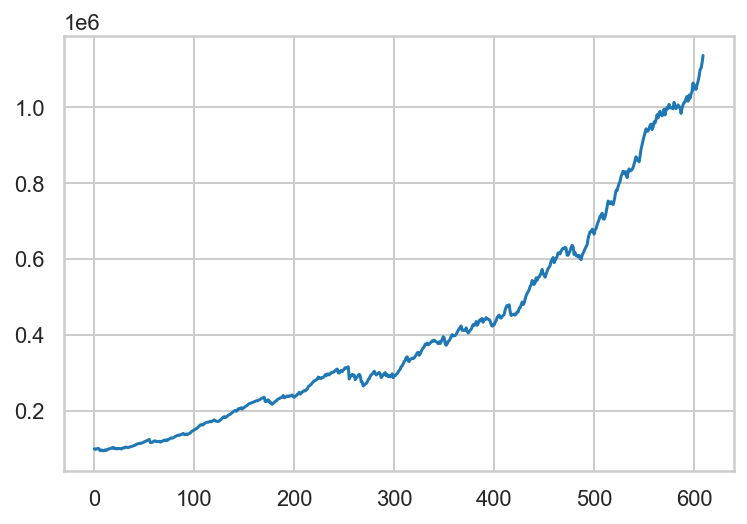

In [31]:
_ = plt.plot( balance )


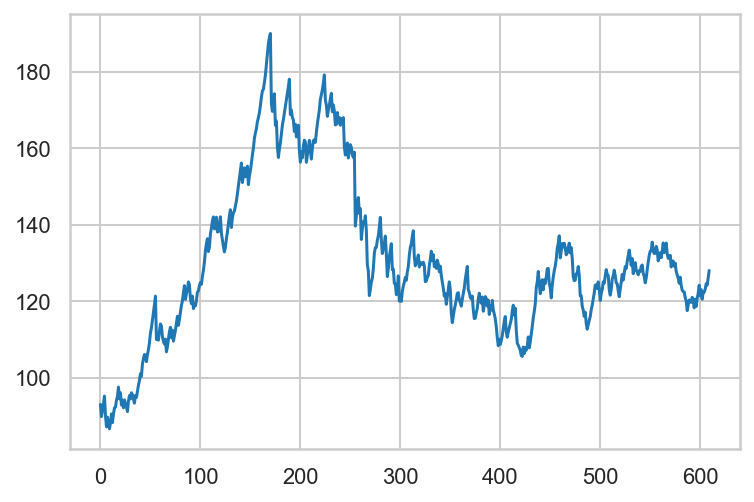

In [32]:
_ = plt.plot( closes )
#_ = plt.plot( strikes )
#_ = plt.plot( profits )

In [33]:
count = len(closes)

days = ( timestamps[count-1] - timestamps[0] ).days
days_per_trade = days / count
trades_per_year = 365 / days_per_trade
final = balance[count-1] / balance[0]

# n^count = final
# count * ln(n) = ln(final)
# ln(n) = ln(final) / count
# n = e ^ (ln(final) / count)
n = np.exp( np.log( final ) / count )

print( 'total trades,       ', count )
print( 'total days,         ', days )
print( 'days per trade,     ', days_per_trade )
print( 'trades per year,    ', trades_per_year )
print( 'gain per trade,     ', n )
print( 'overall gain,       ', n ** count )
#print( 'overall gain check, ', final )
print( 'gain per year,      ', n ** 52 )
print( 'gain of 100k initial,', 100000 * final )

total trades,        610
total days,          3574
days per trade,      5.859016393442623
trades per year,     62.29714605484052
gain per trade,      1.0039905268462603
overall gain,        11.351811626826903
overall gain check,  11.351811626827358
gain per year,       1.2300987642174124
gain of 100k initial, 1135181.1626827358


In [ ]:
# constant parameters
expire = 7                  # expiration interval
oom = 5                     # options offered at each $5 strike interval
vol = 0.2                   # historical median IV
commission = 0.65 / 100     # option contract commission per share (not per contract)
spread = 0.05               # option price difference per contract between bid and ask

# starting state
state = 'cash'

# preinitialized tracking variables
balance = [ 100000 ]
closes = [ close[0] ]
states = [ 1 ]
profits = [ 0 ]

# additional tracking variables
# initialized during cash state
strikes = []
puts = []
timestamps = []

for i, c in enumerate(close):

    # check only between 9am and 4pm
    hourofday = close.index[ i ].hour
    if hourofday >= open_hourofday and hourofday < close_hourofday:

        # state transitions
        # cash      - start from cash, open new positions
        # waiting   - waiting for end of option expiration
        # opened    - close old position(s), and open new
        if state == 'cash':

            # limit underlying
            lots = np.floor( ( balance[-1] / c ) / 100 )

            # open new sell call position
            # sell an OOM call option (note, price is in $/share, not $/100 shares)
            # strike - the nearest OOM strike above the cost
            # c      - the current price of the underlying asset
            # vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
            strike = oom * np.round( np.floor( c - oom ) / oom )
            put_in = options.american( "p", c, strike, expire/365, 0.01, 0.0, vol )[0] - spread

            # track progress
            strikes.append( strike )
            puts.append( put_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format(expire) )
            state = 'waiting'

        elif state == 'waiting':

            # wait for expiration
            if close.index[ i ] > timestamp - pd.Timedelta( '1D' ):
                state = 'expired'
                states.append( 2 )

            elif c < strike:
                state = 'exercised'
                states.append( 3 )

        elif state == 'expired':

            # CLOSE OLD POSITION
            # the put option expired worthless
            # so, we can keep the original sale price
            profit = put_in
            
            # track progress
            balance.append( balance[-1] + profit * 100 * lots - commission * 100 * lots * 2 )
            profits.append( profit )
            closes.append( c )

            # OPEN NEW POSITION
            # limit underlying
            lots = np.floor( ( balance[-1] / c ) / 100 )

            # sell an OOM put option (note, price is in $/share, not $/100 shares)
            # cost   - cost of underlying asset (not necessarily the same as the current price)
            # strike - the nearest OOM strike below the cost
            # c      - the current price of the underlying asset
            # vol = hv[ datetime.date( close.index[ i ].year, close.index[ i ].month, close.index[ i ].day ) ]
            strike = oom * np.round( np.floor( c - oom ) / oom )
            put_in = options.american( "p", c, strike, expire/365, 0.01, 0.0, vol )[0] - spread

            # track strike and lots progress
            strikes.append( strike )
            puts.append( put_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format(expire) )
            state = 'waiting'

        elif state == 'exercised':

            # CLOSE OLD POSITION
            # option was exercised early (it didnt expire)
            # calculate days remaining (remember, timestamp = start + expire time)
            days = ( timestamp - close.index[ i ] ).days
            put_out = options.american( "p", c, strike, days/365, 0.01, 0.0, vol )[0]

            # add profit (loss) from the purchase of the call (to close the short sale at the start)
            profit = put_in - put_out

            # track progress
            balance.append( balance[ -1 ] + profit * 100 * lots - commission * 100 * lots * 2 )
            profits.append( profit )
            closes.append( c )

            # OPEN NEW POSITION
            # limit underlying
            lots = np.floor( ( balance[-1] / c ) / 100 )

            # sell another call in the remaining expire time plus another full expire
            expire_plus = days + expire
            strike = oom * np.round( np.floor( c - oom ) / oom )
            put_in = options.american( "p", c, strike, expire_plus/365, 0.01, 0.0, vol )[0] - spread

            # track strike and lots progress
            strikes.append( strike )
            puts.append( put_in )
            timestamps.append( close.index[i] )

            # update timestamp and state
            timestamp = close.index[ i ] + pd.Timedelta( '{}D'.format( expire_plus ) )
            state = 'waiting'


In [ ]:
_ = plt.plot( balance )


In [ ]:
_ = plt.plot( closes )
_ = plt.plot( strikes )

In [ ]:
_ = plt.plot( profits )

In [ ]:
_ = plt.plot( states )
#np_states = np.array( states )
#_ = plt.plot( np.where( np_states2,1,0 ) )

In [ ]:
count = len(closes)

days = ( timestamps[count-1] - timestamps[0] ).days
days_per_trade = days / count
trades_per_year = 365 / days_per_trade
final = balance[count-1] / balance[0]

# n^count = final
# count * ln(n) = ln(final)
# ln(n) = ln(final) / count
# n = e ^ (ln(final) / count)
n = np.exp( np.log( final ) / count )

print( 'total trades,       ', count )
print( 'total days,         ', days )
print( 'days per trade,     ', days_per_trade )
print( 'trades per year,    ', trades_per_year )
print( 'gain per trade,     ', n )
print( 'overall gain,       ', n ** count )
print( 'overall gain check, ', final )
print( 'gain per year,      ', n ** trades_per_year )
print( 'gain of 100k initial,', 100000 * final )



In [37]:
oom = 10
for cost in [10.1, 14.4, 15.6, 19.99]:
    print( oom * np.round( np.ceil( cost + oom ) / oom ) )



20.0
20.0
30.0
30.0
